In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hyperspectral-blueberries/Good Blueberry 169-210.bil.hdr
/kaggle/input/hyperspectral-blueberries/Bad Blueberries 1-42.bil
/kaggle/input/hyperspectral-blueberries/Bad Blueberries 127-168.bil
/kaggle/input/hyperspectral-blueberries/Good Blueberry 127-168.bil
/kaggle/input/hyperspectral-blueberries/Good Blueberry 85-126.bil.hdr
/kaggle/input/hyperspectral-blueberries/WhiteReference.bil.hdr
/kaggle/input/hyperspectral-blueberries/WhiteReference.bil
/kaggle/input/hyperspectral-blueberries/Bad Blueberry 43-84.bil.hdr
/kaggle/input/hyperspectral-blueberries/Bad Blueberry 85-126.bil.hdr
/kaggle/input/hyperspectral-blueberries/Good Blueberry 127-168.bil.hdr
/kaggle/input/hyperspectral-blueberries/Good Blueberry 43-84.bil.hdr
/kaggle/input/hyperspectral-blueberries/Bad Blueberries 169-210.bil
/kaggle/input/hyperspectral-blueberries/Bad Blueberry 1-42.bil.hdr
/kaggle/input/hyperspectral-blueberries/Good Blueberry 1-42.bil
/kaggle/input/hyperspectral-blueberries/Bad Blueberries 169-2

In [52]:
!pip install spectral numpy pandas matplotlib seaborn scikit-learn

In [53]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
import umap
import warnings
warnings.filterwarnings('ignore')

In [55]:
# Cell 2: Data Preparation
def prepare_data(good_spectra, bad_spectra):
    # Combine data and create labels
    X = np.vstack([good_spectra, bad_spectra])
    y = np.hstack([np.ones(len(good_spectra)), np.zeros(len(bad_spectra))])
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Prepare your data
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(results['good'], results['bad'])

In [59]:
# Cell 3: Model Training
def train_models(X_train_scaled, X_test_scaled, y_train, y_test):
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Neural Network': MLPClassifier(random_state=42)
    }
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Train the model
        model.fit(X_train_scaled, y_train)
        
        # Predictions
        y_pred = model.predict(X_test_scaled)
        
        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
        
        # Classification report
        report = classification_report(y_test, y_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'predictions': y_pred,
            'cv_scores': cv_scores,
            'report': report
        }
        
        # ROC Curve and AUC (if supported)
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_test_scaled)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, proba)
            results[name]['roc'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc(fpr, tpr)}
    
    return results

# Train the models and store the results
model_results = train_models(X_train_scaled, X_test_scaled, y_train, y_test)

# Verify the results
for model_name, result in model_results.items():
    print(f"{model_name} - Average CV Score: {result['cv_scores'].mean():.4f}")
    if 'roc' in result:
        print(f"{model_name} - AUC: {result['roc']['auc']:.4f}")

Training Random Forest...
Training SVM...
Training Gradient Boosting...
Training Neural Network...
Random Forest - Average CV Score: 0.2300
Random Forest - AUC: 0.2000
SVM - Average CV Score: 0.3700
SVM - AUC: 1.0000
Gradient Boosting - Average CV Score: 0.5200
Gradient Boosting - AUC: 0.0000
Neural Network - Average CV Score: 0.3300
Neural Network - AUC: 0.6000


In [60]:
# Cell 4: Dimensionality Reduction
def perform_dim_reduction(X_train_scaled):
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_train_scaled)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, X_train_scaled.shape[0] - 1))
    tsne_result = tsne.fit_transform(X_train_scaled)

    # UMAP
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(X_train_scaled)

    return pca_result, tsne_result, umap_result

# Perform dimensionality reduction
pca_result, tsne_result, umap_result = perform_dim_reduction(X_train_scaled)

# Verify the results are defined
print("PCA result shape:", pca_result.shape)
print("t-SNE result shape:", tsne_result.shape)
print("UMAP result shape:", umap_result.shape)

PCA result shape: (21, 2)
t-SNE result shape: (21, 2)
UMAP result shape: (21, 2)


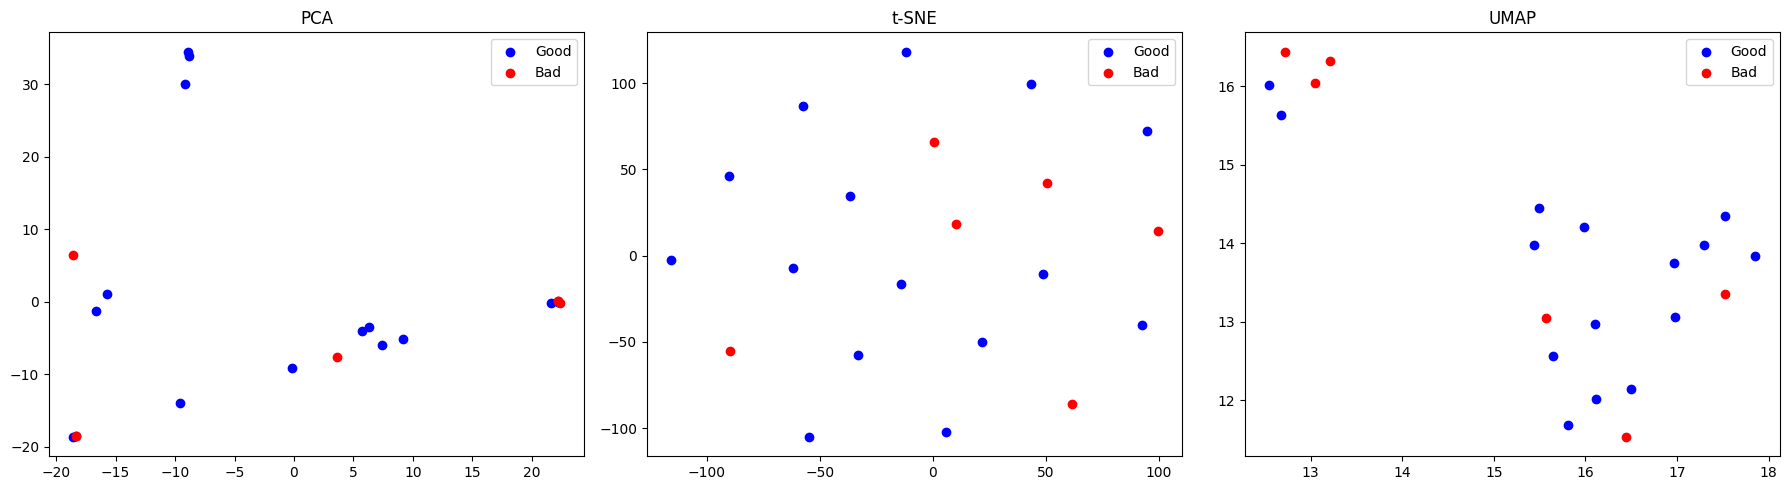

In [62]:
# Cell 5: Visualization Functions
def plot_dimensionality_reduction(pca_result, tsne_result, umap_result, n_good_samples):
    """
    Visualize the results of PCA, t-SNE, and UMAP dimensionality reductions.
    
    Parameters:
        pca_result (array): Result of PCA dimensionality reduction.
        tsne_result (array): Result of t-SNE dimensionality reduction.
        umap_result (array): Result of UMAP dimensionality reduction.
        n_good_samples (int): Number of "good" samples in the dataset.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # PCA Plot
    axes[0].scatter(pca_result[:n_good_samples, 0], pca_result[:n_good_samples, 1], 
                     c='blue', label='Good')
    axes[0].scatter(pca_result[n_good_samples:, 0], pca_result[n_good_samples:, 1], 
                     c='red', label='Bad')
    axes[0].set_title('PCA')
    axes[0].legend()
    
    # t-SNE Plot
    axes[1].scatter(tsne_result[:n_good_samples, 0], tsne_result[:n_good_samples, 1], 
                     c='blue', label='Good')
    axes[1].scatter(tsne_result[n_good_samples:, 0], tsne_result[n_good_samples:, 1], 
                     c='red', label='Bad')
    axes[1].set_title('t-SNE')
    axes[1].legend()
    
    # UMAP Plot
    axes[2].scatter(umap_result[:n_good_samples, 0], umap_result[:n_good_samples, 1], 
                     c='blue', label='Good')
    axes[2].scatter(umap_result[n_good_samples:, 0], umap_result[n_good_samples:, 1], 
                     c='red', label='Bad')
    axes[2].set_title('UMAP')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

# Define the number of "good" samples
n_good_samples = len(results['good'])  # Replace "results['good']" if your variable name is different.

# Plot dimensionality reduction results
plot_dimensionality_reduction(pca_result, tsne_result, umap_result, n_good_samples)

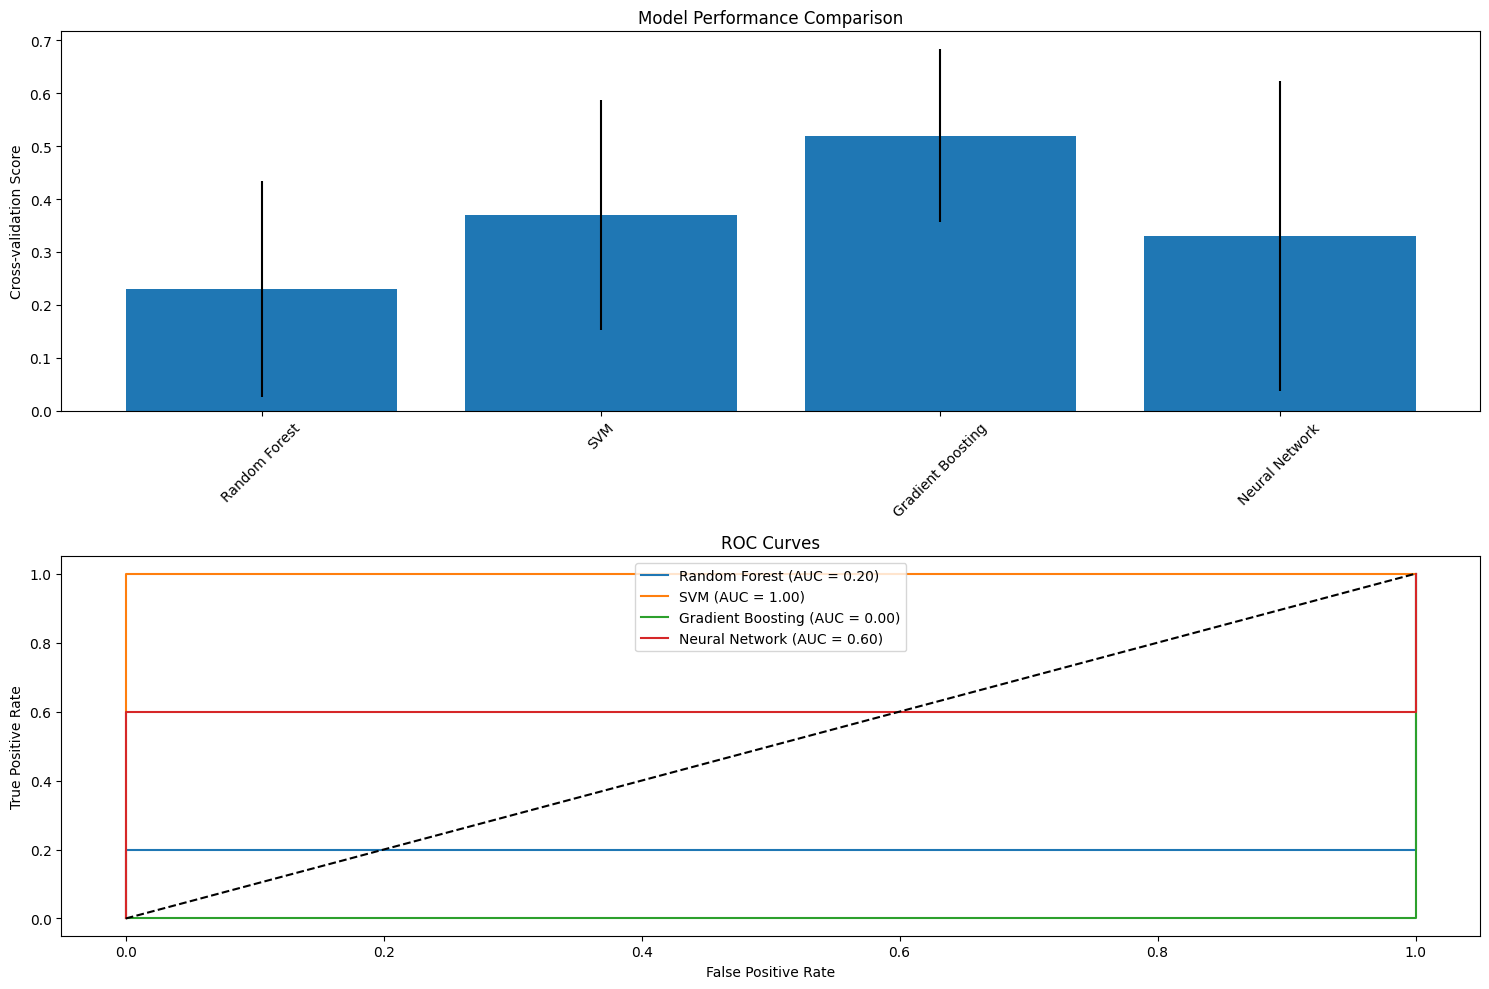

In [63]:
# Cell 6: Model Performance Visualization
def plot_model_performance(model_results):
    plt.figure(figsize=(15, 10))
    
    # Model Performance Comparison
    plt.subplot(2, 1, 1)
    model_names = list(model_results.keys())
    cv_means = [results['cv_scores'].mean() for results in model_results.values()]
    cv_stds = [results['cv_scores'].std() for results in model_results.values()]
    
    plt.bar(model_names, cv_means, yerr=cv_stds)
    plt.title('Model Performance Comparison')
    plt.xticks(rotation=45)
    plt.ylabel('Cross-validation Score')
    
    # ROC Curves
    plt.subplot(2, 1, 2)
    for name, results in model_results.items():
        if 'roc' in results:
            plt.plot(results['roc']['fpr'], results['roc']['tpr'], 
                    label=f'{name} (AUC = {results["roc"]["auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_model_performance(model_results)

In [64]:
# Cell 7: Best Model Optimization
def optimize_random_forest(X_train_scaled, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

best_model = optimize_random_forest(X_train_scaled, y_train)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.22999999999999998


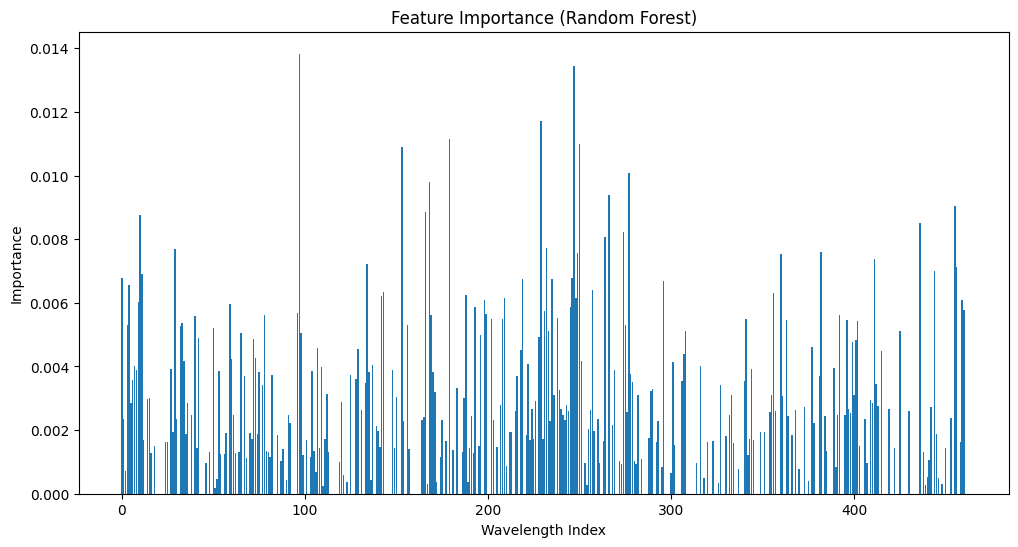

In [66]:
# Cell 8: Feature Importance Analysis
def plot_feature_importance(best_model, X_train_scaled):
    plt.figure(figsize=(12, 6))
    importance = best_model.feature_importances_
    plt.bar(range(len(importance)), importance)
    plt.title('Feature Importance (Random Forest)')
    plt.xlabel('Wavelength Index')
    plt.ylabel('Importance')
    plt.show()

plot_feature_importance(best_model, X_train_scaled)